In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData
import os
from glob import glob
import hera_pspec as hp
from hera_pspec.data import DATA_PATH
import time

/lustre/aoc/projects/hera/jaguirre/anaconda3/envs/hera/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
real_path = '/lustre/aoc/projects/hera/plaplant/HERA19Golden/'
sim_path = '/lustre/aoc/projects/hera/plaplant/HERA19Golden/Simulation/'

In [4]:
auto_xx = UVData()
auto_xx.read(real_path+'zen.2457548.xx.HH.auto10.uvcRPCS.uvh5')
sim_xx = UVData()
sim_xx.read(sim_path+'zen.2457756.14819.xx.HH.uvCP.autos.uvh5')

LST values stored in /lustre/aoc/projects/hera/plaplant/HERA19Golden/zen.2457548.xx.HH.auto10.uvcRPCS.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


In [5]:
bl = (10,10)
real_lst = auto_xx.lst_array.squeeze()*24./(2.*np.pi)
real_freq = auto_xx.freq_array.squeeze()/1e6
real_flags = ~auto_xx.get_flags(bl,force_copy=True)
bl_sim = (9,9)
sim_lst = sim_xx.lst_array.squeeze()*24./(2.*np.pi)
sim_freq = sim_xx.freq_array.squeeze()/1e6
sim_flags = ~sim_xx.get_flags(bl_sim,force_copy=True)

In [7]:
print real_lst.shape
print real_freq.shape

(4021,)
(1024,)


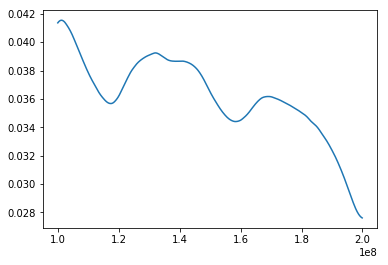

In [8]:
freqs = real_freq*1e6
# Bring in the beam calibration to K
cosmo = hp.conversions.Cosmo_Conversions()
# List of beamfile to load. This is a healpix map.
beamfile = os.path.join(DATA_PATH, 'NF_HERA_Beams.beamfits')
# intantiate beam and pass cosmology, if not fed, a default Planck cosmology will be assumed
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)
# find conversion factor from Jy to K.  xx and yy are the same.
Jy_to_K = uvb.Jy_to_mK(freqs,pol='xx')/1000.

# Plot it
plt.plot(freqs,Jy_to_K)
plt.show()

In [9]:
real_data = auto_xx.get_data(bl,force_copy=True).real*Jy_to_K
sim_data = sim_xx.get_data(bl_sim,force_copy=True).real*Jy_to_K

divide by zero encountered in divide
invalid value encountered in divide


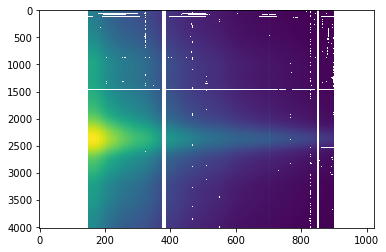

In [10]:
plt.imshow(real_data.real/real_flags,aspect='auto')
plt.show()

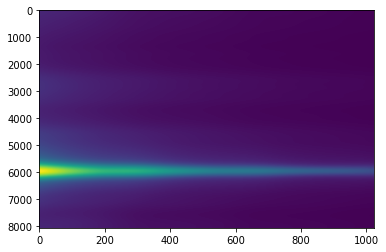

In [11]:
plt.imshow(sim_data.real/sim_flags,aspect='auto')
plt.show()

divide by zero encountered in divide
invalid value encountered in divide


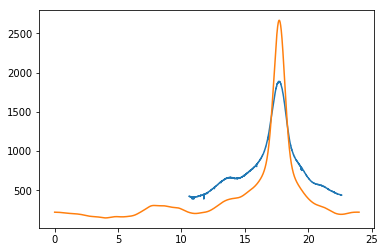

In [12]:
plt.plot(real_lst,((real_data/real_flags)[:,np.argmin(np.abs(real_freq-160.))]))
plt.plot(sim_lst,(sim_data/sim_flags)[:,np.argmin(np.abs(sim_freq-160.))])

divide by zero encountered in divide
invalid value encountered in divide


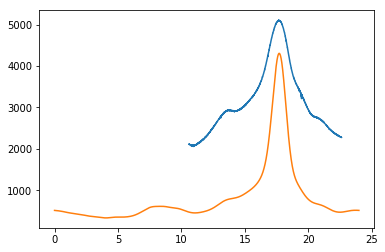

In [13]:
plt.plot(real_lst,((real_data/real_flags)[:,np.argmin(np.abs(real_freq-120.))]))
plt.plot(sim_lst,(sim_data/sim_flags)[:,np.argmin(np.abs(sim_freq-120.))])

In [14]:
sim_interp = np.zeros_like(real_data)
print real_data.shape
print sim_data.shape
nt, nf = real_data.shape

(4021, 1024)
(8052, 1024)


In [16]:
for f in np.arange(nf):
    sim_interp[:,f] = np.interp(real_lst,sim_lst,sim_data[:,f])

divide by zero encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


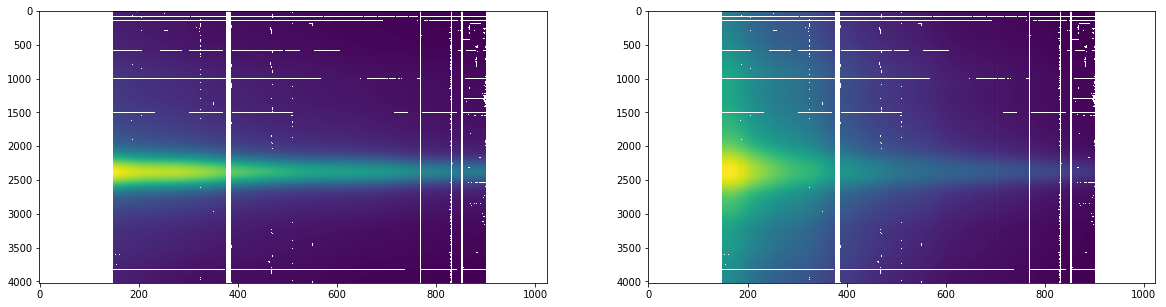

In [20]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(sim_interp/real_flags,aspect='auto')
plt.subplot(122)
plt.imshow(real_data/real_flags,aspect='auto')
plt.show()

divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide


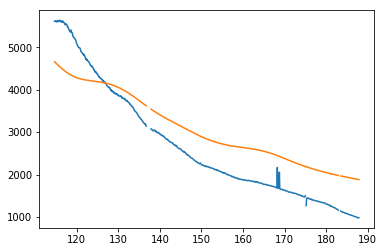

In [22]:
plt.plot(real_freq,(real_data/real_flags)[2400,:])
plt.plot(real_freq,(sim_interp/real_flags)[2400,:])

divide by zero encountered in divide
invalid value encountered in divide


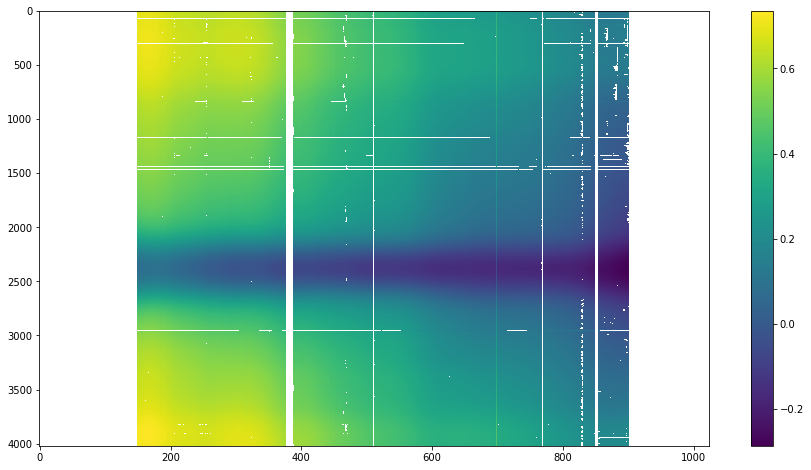

In [44]:
plt.figure(figsize=(15,8))
plt.imshow(np.log10(real_data/sim_interp/real_flags),aspect='auto')
plt.colorbar()
plt.show()

divide by zero encountered in divide


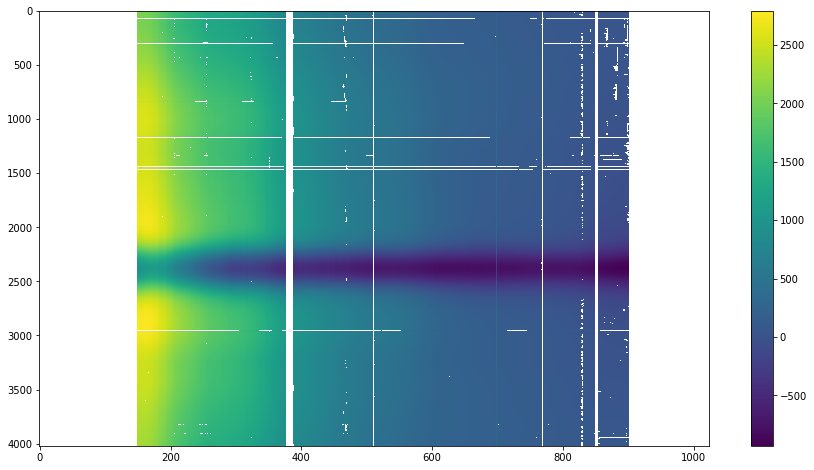

In [28]:
plt.figure(figsize=(15,8))
plt.imshow((real_data-sim_interp)/real_flags,aspect='auto')
plt.colorbar()
plt.show()

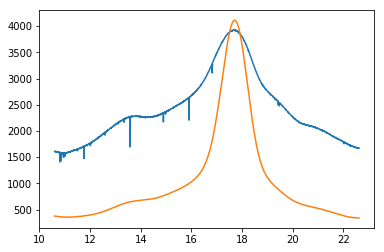

In [30]:
plt.plot(real_lst,real_data[:,300])
plt.plot(real_lst,sim_interp[:,300])

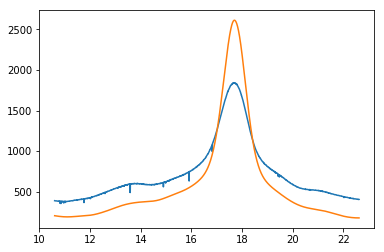

In [45]:
plt.plot(real_lst,real_data[:,650])
plt.plot(real_lst,sim_interp[:,650])

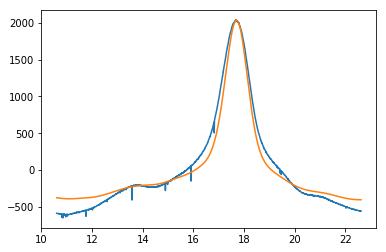

In [38]:
plt.plot(real_lst,(real_data[:,650]-real_data[:,650].mean())*1.8)
plt.plot(real_lst,sim_interp[:,650]-sim_interp[:,650].mean())

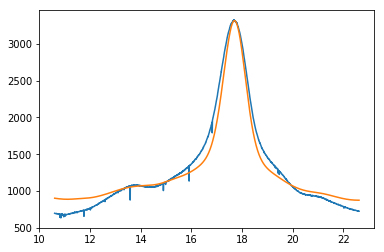

In [43]:
plt.plot(real_lst,real_data[:,650]*1.8)
plt.plot(real_lst,sim_interp[:,650]+700.)

In [49]:
# It's pretty clear that the simulation is just not a good description of the data.  So ... what would make it better?

In [47]:
import linsolve

In [91]:
%%time
""" This is kind of a tedious way to set up the system of equations.  The idea here is that g and n are the 
frequency-dependent (because they are fit at each frequency independently) gain and receiver temperature necessary
to make the simulation match the data, averaged over all times.  """
data = {}
wgts = {}
kwargs = {}
# At each frequency, subtract the average over time
sim_interp_shape = np.zeros_like(sim_interp)
for i in np.arange(nf):
    sim_interp_shape[:,i] = sim_interp[:,i] - sim_interp[:,i].mean()
for i in np.arange(nt):
    data['sim%d*g+n' % i] = real_data[i, :]
    wgts['sim%d*g+n' % i] = real_flags[i, :]
    kwargs['sim%d' % i] = sim_interp_shape[i,:]

CPU times: user 339 ms, sys: 11.9 ms, total: 350 ms
Wall time: 350 ms


In [92]:
ls = linsolve.LinearSolver(data, wgts, **kwargs)

In [93]:
sol = ls.solve()

In [94]:
freq_flags = np.sum(real_flags,axis=0)
ugh = freq_flags > 3500
nugh = ~ugh
print ugh.shape
freq_flags[ugh] = 1
freq_flags[nugh] = 0

(1024,)


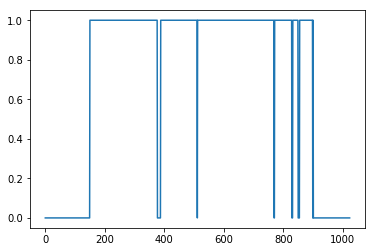

In [95]:
plt.plot(freq_flags)

divide by zero encountered in divide
invalid value encountered in divide


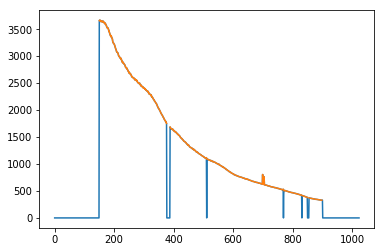

In [96]:
plt.plot(sol['n'])
plt.plot(sol['n']/freq_flags)

divide by zero encountered in divide
invalid value encountered in divide


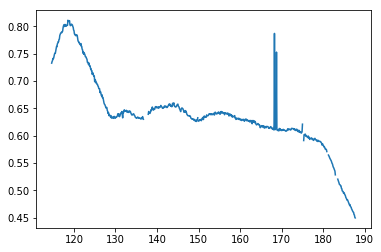

In [101]:
plt.plot(real_freq,sol['g']/freq_flags)

In [104]:
best_sim = sim_interp/real_flags*np.outer(np.ones(nt),sol['g'])+np.outer(np.ones(nt),sol['n'])

divide by zero encountered in divide
invalid value encountered in multiply


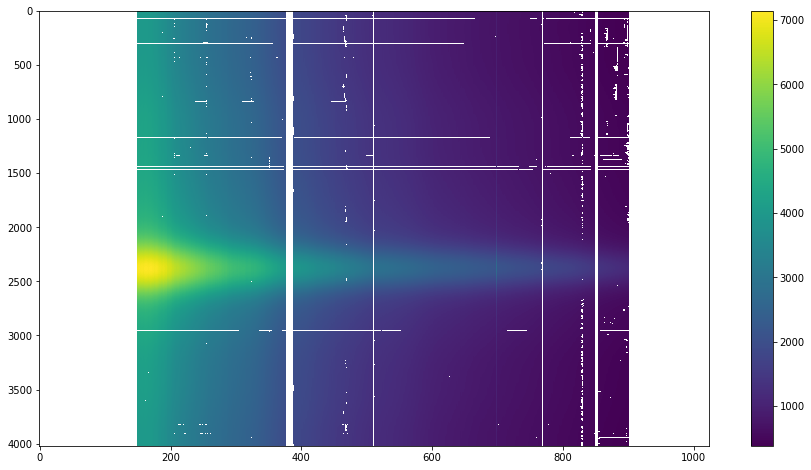

In [105]:
plt.figure(figsize=(15,8))
plt.imshow(best_sim,aspect='auto')
plt.colorbar()
plt.show()

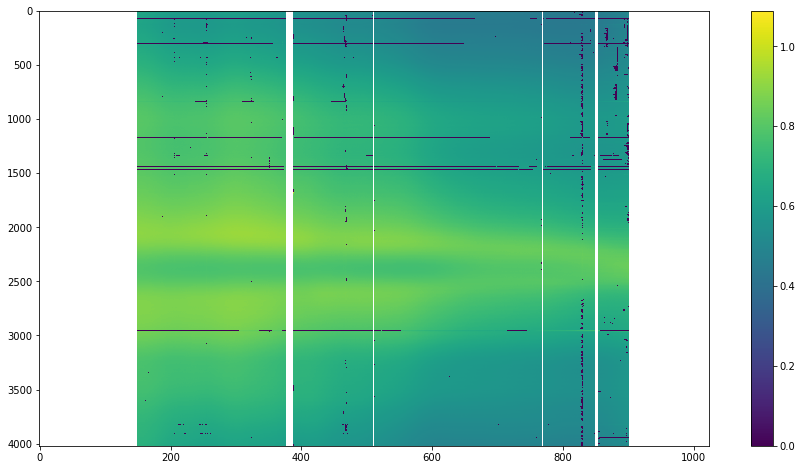

In [106]:
plt.figure(figsize=(15,8))
plt.imshow(real_data/best_sim,aspect='auto')
plt.colorbar()
plt.show()

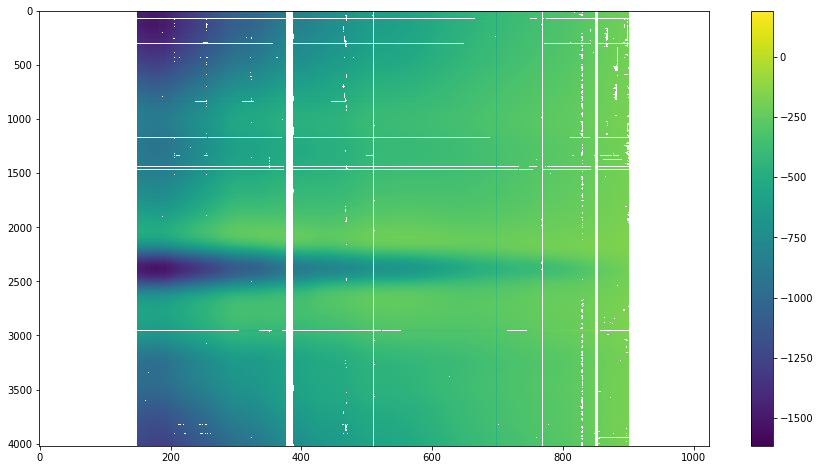

In [107]:
plt.figure(figsize=(15,8))
plt.imshow(real_data-best_sim,aspect='auto')
plt.colorbar()
plt.show()

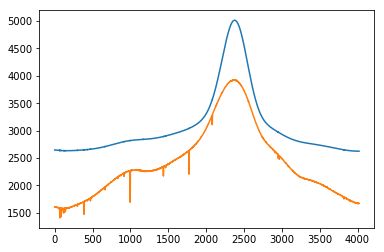

In [108]:
plt.plot(best_sim[:,300])
plt.plot(real_data[:,300])

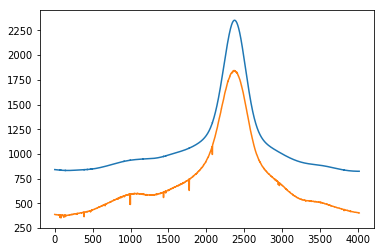

In [109]:
plt.plot(best_sim[:,650])
plt.plot(real_data[:,650])